In [99]:
pip install imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [73]:
import nltk
nltk.download('omw-1.4')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dhritigampa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dhritigampa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dhritigampa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dhritigampa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import re

# Load the CSV file
df = pd.read_csv('Cleaned_Economic_News_Relabeled.csv', encoding='ISO-8859-1')

# Step 2: Drop rows where any of the relevant columns have NaN or empty values
df_cleaned = df.dropna(subset=['headline', 'sentiment'])

# Optionally, remove any rows where the headline column is empty or contains only whitespace
df_cleaned = df_cleaned[df_cleaned['headline'].str.strip().astype(bool)]

# Step 3: Create a new column 'sentiment' based on the positivity score
def categorize_sentiment(positivity):
    if positivity == -1:
        return 'negative'
    elif positivity == 0:
        return 'neutral'
    elif positivity == 1:
        return 'positive'
    else:
        return None  # In case there are out-of-range values

df_cleaned['sentiment'] = df_cleaned['sentiment'].apply(categorize_sentiment)

# Step 4: Preprocess the headline
def preprocess_headline(headline):
    # Convert text to lowercase
    headline = headline.lower()
    
    # Replace numbers with <NUMBER>
    headline = re.sub(r'\b\d+(\.\d+)?\b', '<NUMBER>', headline)
    
    # Replace percentages with <PERCENTAGE>
    headline = re.sub(r'\d+(\.\d+)?%', '<PERCENTAGE>', headline)
    
    # Replace other numerical representations (e.g., currency) if necessary
    headline = re.sub(r'\$\d+(\.\d+)?', '<CURRENCY>', headline)  # Replace currency amounts
    headline = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '<DATE>', headline)  # Replace dates

    # Remove non-alphanumeric characters (except spaces and punctuation)
    headline = re.sub(r'[^\w\s\.,!?\'":;()-]', '', headline)

    # Optional: Remove excessive whitespace
    headline = re.sub(r'\s+', ' ', headline).strip()
    
    return headline

# Apply preprocessing to the 'headline' column only
df_cleaned['cleaned_headline'] = df_cleaned['headline'].apply(preprocess_headline)

# Step 5: Check the cleaned data (only showing headlines here)
print(df_cleaned[['headline', 'cleaned_headline']].head())


                                            headline  \
0              Yields on CDs Fell in the Latest Week   
1  Currency Trading: Dollar Remains in Tight Rang...   
2               Stocks Fall Again; BofA, Alcoa Slide   
3  U.S. Dollar Falls Against Most Currencies; Dec...   
4               Defending Yourself Against Deflation   

                                    cleaned_headline  
0              yields on cds fell in the latest week  
1  currency trading: dollar remains in tight rang...  
2               stocks fall again; bofa, alcoa slide  
3  u.s. dollar falls against most currencies; dec...  
4               defending yourself against deflation  


neutral     418
negative    418
positive    418
Name: sentiment, dtype: int64


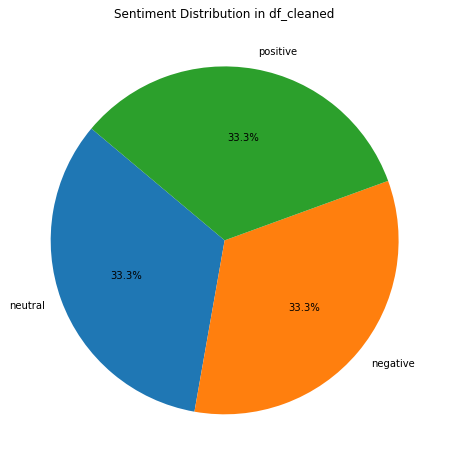

In [132]:
# Get the counts of each sentiment class
class_counts = df_cleaned['sentiment'].value_counts()

target_count = class_counts.min()
df_neutral = df_cleaned[df_cleaned['sentiment'] == 'neutral'].sample(target_count, random_state=42)
df_pos = df_cleaned[df_cleaned['sentiment'] == 'positive'].sample(target_count, random_state=42)
df_neg = df_cleaned[df_cleaned['sentiment'] == 'negative'].sample(target_count, random_state=42)

df_balanced = pd.concat([df_neg, df_pos,
                         df_neutral])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Count the occurrences of each sentiment
sentiment_counts = df_balanced['sentiment'].value_counts()
print(sentiment_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in df_cleaned')
plt.show()

Test Accuracy: 0.4701
Classification Report:
              precision    recall  f1-score   support

    negative       0.39      0.35      0.37        83
     neutral       0.62      0.48      0.54        84
    positive       0.44      0.58      0.50        84

    accuracy                           0.47       251
   macro avg       0.48      0.47      0.47       251
weighted avg       0.48      0.47      0.47       251



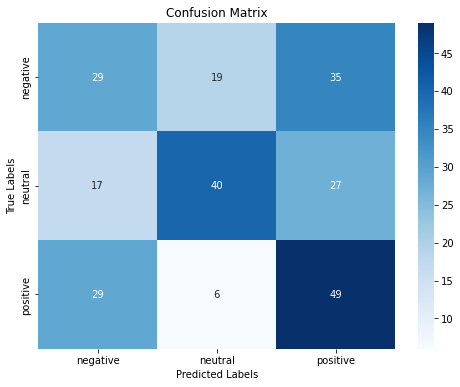

In [134]:
# Preprocess headlines
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_balanced['processed_headline'] = df_balanced['cleaned_headline'].apply(preprocess_text)

# Train Word2Vec model on the processed headlines
word2vec_model = Word2Vec(
    sentences=df_balanced['processed_headline'],
    vector_size=200,  # Dimension of the word vectors
    window=5,         # Context window size
    min_count=1,      # Minimum frequency for words to be included
    sg=1,             # Skip-gram model
    epochs=10,        # Number of training epochs
    workers=4         # Use multiple threads
)


# Generate headline embeddings by averaging word vectors
def get_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df_balanced['headline_vector'] = df_balanced['processed_headline'].apply(lambda tokens: get_embedding(tokens, word2vec_model))

# Prepare data for training
X = np.vstack(df_balanced['headline_vector'].values)
y = df_balanced['sentiment']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()